# 1. 读取train.csv和test.csv

In [147]:
import torch
from torch.utils import data
import pandas as pd
import matplotlib.pyplot as plt

train_data = pd.read_csv("../data/train.csv")
test_data = pd.read_csv("../data/test.csv")
# 剔除一些列
def filter_missing(cols, data, rate):
    data = data.drop(columns=cols, axis=1)
    missing = data.isnull().sum()
    missing = missing[missing>int(data.shape[0]*rate)]
    data = data.drop(columns=dict(missing).keys(), axis=1)
    return data

重写一个data_preprocess函数, 对原始数据train_data, test_data进行处理
1. 分离出train_labels
2. 将train和test按行拼接为data, 方便处理
3. 对于数值类型的特征均值归一化, 对于缺失值赋值0
4. 对于分类特征进行one-hot处理, 可以剔除Nan值比较多的列
5. dummy后的特征可以进行PCA降维

In [148]:
def data_preprocess(train_data, test_data, rate=1):
    train_labels = train_data["SalePrice"]
    train_features = filter_missing(["Id", "SalePrice"], train_data, rate) # 不剔除
    test_features = filter_missing(["Id"], test_data, 1) # 不剔除
    all_features = pd.concat([train_features, test_features], axis=0)
    # all_features中的numeric_features进行均值归一化
    numeric = [f for f in all_features.columns if all_features.dtypes[f] != 'object']
    all_features[numeric] = all_features[numeric].apply(lambda x: (x-x.mean())/x.std())
    all_features[numeric] = all_features[numeric].fillna(0) # 注意这句非常重要
    # 否则后面训练损失全是nan值都不晓得发生什么事了
    # pd.get_dummies()可以将分类特征进行one-hot编码, 它自动识别字符串分类特征
    all_features = pd.get_dummies(all_features, dummy_na=True)
    train_size = train_data.shape[0]
    train_X = torch.tensor(all_features[:train_size].values, dtype=torch.float32)
    test_X = torch.tensor(all_features[train_size:].values, dtype=torch.float32)
    train_y = torch.tensor(train_labels.values, dtype=torch.float32)
    return train_X, train_y, test_X

# 2. 模型评估指标RMSLE
RMSE(均方根误差)是常用的误差指标, 衡量了绝对误差, 而RMSLE(均方根对数误差)则提供了一种测量相对误差的方法:
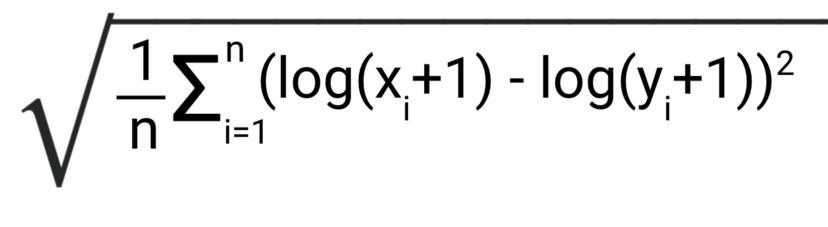
[参考链接:What’s the Difference Between RMSE and RMSLE?](https://medium.com/analytics-vidhya/root-mean-square-log-error-rmse-vs-rmlse-935c6cc1802a)
请注意，在公式中，X 是预测值，Y 是实际值。相对误差是由于$log$的减法实际可变为除法的形式，另外RMSLE 对实际变量的低估比高估的惩罚更大

In [149]:
import math
def rmsle(y_hat, y):
    inner = torch.pow((torch.log(y_hat+1)-torch.log(y)), 2).sum()/len(y)
    return math.sqrt(inner)
ty = torch.tensor([1000])
ty_0 = torch.tensor([600])
ty_1 = torch.tensor([1400])
rmsle(ty_0, ty), rmsle(ty_1, ty)

(0.509160526736003, 0.3371863329268826)

# 3. K-fold交叉验证
将训练数据等分为K份, 其中K-1份用于训练, 另一份用于验证。这样的训练可以进行M次。本次训练数据统共1460条，不妨进行10次10折交叉验证。为此，训练流程如下:
> 1. initialize model, loss, optim
> 2. shuffle the data
> 3. data_split(data, K, i)--> train_data, valid_data  
    """将data划分为K份, 返回第i份作为valid_data, 其余k-1份合并为train_data"""
> 4. train_single(train_data, valid_data)--> rmsle  
    """"进行单次训练, 返回rmsle损失""""
> 5. loop 3-to-4 for i=0 to K-1
> 6. loop 2-to-5 for j=0 to M-1

### 3-1 模型、损失函数、优化函数的初始化

In [150]:
from torch import nn

# 以后初始化就固定这个模式xv_init+apply
def get_model(n_in, n_out):
    model = nn.Sequential(nn.Linear(n_in, n_out))
    def xv_init(m):
        if type(m) == nn.Linear:
            n_in = m.weight.data.shape[1]
            n_out = m.weight.data.shape[0]
            std = math.sqrt(2/(n_in+n_out))
            nn.init.normal_(m.weight, std=std)
    model.apply(xv_init)
    return model
# MSELoss
def get_loss():
    return nn.MSELoss()
# optim的使用Adam(相对于SGD的优化版), 默认L2惩罚
def get_optim(param, lr=0.001, punish=0):
    return torch.optim.Adam(param, lr=lr, weight_decay=punish)

### 3-2 训练函数

In [151]:
def shuffle(X, y):
    y = y.reshape(-1, 1)
    data = torch.concat([X, y], dim=1)
    data = data[torch.randperm(data.size(0))] # 按行打乱
    return data[:, :-1], data[:, -1]

def split(X, y, i, K=10):
    """X[m, d], y[m], 将X, y分成K块, 第i块作为valid, 其余的作为train集"""
    y = y.reshape(-1, 1)
    data = torch.concat([X, y], dim=1)
    chunks = torch.chunk(data, K)
    valid_ = chunks[i]
    train_chunk_list = [chunks[j] for j in range(K) if j!= i]
    train_ = torch.concat(train_chunk_list, dim=0)
    return train_[:, :-1], train_[:, -1], valid_[:, :-1], valid_[:, -1]

def train(train_features, train_labels, lr=0.001, punish=0, m=10, K=10, batch_size=100):
    features_num = train_features.shape[1]
    model = get_model(features_num, 1)
    loss = get_loss()
    optim = get_optim(model.parameters(), lr=lr, punish=punish)
    val_rmsle, val_rmse = [], []
    # 进行m次k折训练
    for i in range(m):
        # 对 feature 和 label 打乱, 注意对应不变
        trf, trl = shuffle(train_features, train_labels)
        # 使用chunk()函数
        for j in range(K):
            train_X, train_y, val_X, val_y = split(trf, trl, j, K)
            train_y = train_y.reshape(-1,1)
            val_y = val_y.reshape(-1,1)
            # 构造train_dataset, 进行小批量随机梯度下降训练
            train_dataset = data.TensorDataset(train_X, train_y)
            train_iter = data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
            for X, y in train_iter:
                l = loss(model(X), y)
                optim.zero_grad()
                l.backward()
                optim.step()
            # 计算验证集的rmsle损失
            val_rmsle.append(float(rmsle(model(val_X), val_y)))
            val_rmse.append(float(loss(model(val_X), val_y)))
        if i%10 == 0:
            print(f"第{i+1}次{K}折训练后, 验证集rmsle = {val_rmsle[-1]:.5f}")
#         print(f"第{i+1}次{K}折训练后, 验证集rmse = {val_rmse[-1]:.5f}")
    return model, val_rmsle, val_rmse

### 3-3 放入数据，开始训练

In [153]:
train_X, train_y, test_X = data_preprocess(train_data, test_data, rate=0.3)
model, val_rmsle, val_rmse = train(
    train_X, 
    train_y, 
    lr=0.8, 
    K=12, 
    m=100, 
    batch_size=128
)
float(rmsle(model(train_X), train_y))

第1次12折训练后, 验证集rmsle = 3.63230
第11次12折训练后, 验证集rmsle = 1.34365
第21次12折训练后, 验证集rmsle = 0.72876
第31次12折训练后, 验证集rmsle = 0.42992
第41次12折训练后, 验证集rmsle = 0.24919
第51次12折训练后, 验证集rmsle = 0.18983
第61次12折训练后, 验证集rmsle = 0.18212
第71次12折训练后, 验证集rmsle = 0.13989
第81次12折训练后, 验证集rmsle = 0.12011
第91次12折训练后, 验证集rmsle = 0.14738


21.50850136814547

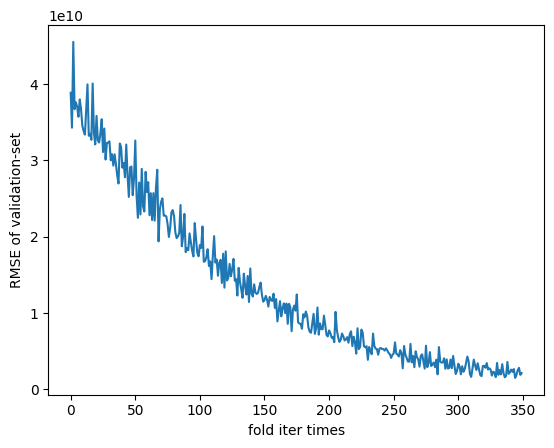

In [122]:
plt.plot(range(len(val_rmse)), val_rmse)
plt.xlabel("fold iter times")
plt.ylabel("RMSE of validation-set")
plt.show()

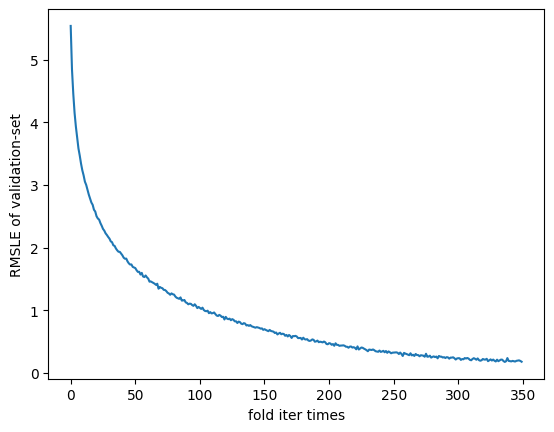

In [123]:
plt.plot(range(len(val_rmsle)), val_rmsle)
plt.xlabel("fold iter times")
plt.ylabel("RMSLE of validation-set")
plt.show()

In [155]:
# 进行预测
test_predict = model(test_X).detach()
test_Ids = torch.tensor(test_data["Id"].values, dtype=int)
test_Ids = test_Ids.reshape(-1, 1)
submmision = torch.concat([test_Ids, test_predict], dim=1).numpy()
submmision = pd.DataFrame(submmision, columns=["Id", "SalePrice"])
submmision["Id"] = submmision["Id"].astype(int)
submmision.to_csv("../output/subm3.csv", index=False)

In [154]:
# 将训练的模型保存
model_name =  f"../model/rate0D3_lr0D8_K12_m100_bs128"
torch.save(model, model_name)

如何将tensor按行打乱？

In [37]:
a=torch.rand(3,5)
print(a)
 
a=a[torch.randperm(a.size(0))]
print(a)
 
a=a[:,torch.randperm(a.size(1))]
print(a)

tensor([[0.8713, 0.4532, 0.4684, 0.8967, 0.9656],
        [0.0518, 0.3665, 0.6943, 0.1538, 0.6272],
        [0.9003, 0.9384, 0.1884, 0.2341, 0.4244]])
tensor([[0.0518, 0.3665, 0.6943, 0.1538, 0.6272],
        [0.9003, 0.9384, 0.1884, 0.2341, 0.4244],
        [0.8713, 0.4532, 0.4684, 0.8967, 0.9656]])
tensor([[0.6943, 0.3665, 0.0518, 0.6272, 0.1538],
        [0.1884, 0.9384, 0.9003, 0.4244, 0.2341],
        [0.4684, 0.4532, 0.8713, 0.9656, 0.8967]])


tensor的合并

In [41]:
a = torch.tensor([[1, 2, 3], [4, 5, 6.0]])
b = torch.tensor([0.3, 0.4]).reshape(-1, 1)
c = torch.concat([a, b], dim=1)
c[:, :-1], c[:, -1]

(tensor([[1., 2., 3.],
         [4., 5., 6.]]),
 tensor([0.3000, 0.4000]))

[Pytorch | tensor 切分方法](https://zhuanlan.zhihu.com/p/339299447)  
chunk:
> 功能：输入数据与想要切分的块数 chunks ，将数据尽可能 (如果数据个数与块数能整除的话) 平均的切分为 chunks 块
* input - tensor
* chunks - 切分的块数
* dim - int - 切分的维度

In [59]:
k = 4
x = torch.randn(8, 3)
y = torch.chunk(x, k, dim=0) # 按行分块
ckl = [y[i] for i in range(k) if i!=1]
x, torch.concat(ckl, dim=0)

(tensor([[ 1.0849,  1.6018, -0.1879],
         [ 2.0239, -0.3448, -0.0176],
         [-0.1884, -0.3717, -0.2333],
         [-1.7931,  0.5974,  1.0945],
         [-0.0447,  0.7323,  0.0042],
         [ 0.6941, -1.8956,  1.1834],
         [-0.6712,  0.7138,  0.1963],
         [ 1.5769,  2.6352, -1.0810]]),
 tensor([[ 1.0849,  1.6018, -0.1879],
         [ 2.0239, -0.3448, -0.0176],
         [-0.0447,  0.7323,  0.0042],
         [ 0.6941, -1.8956,  1.1834],
         [-0.6712,  0.7138,  0.1963],
         [ 1.5769,  2.6352, -1.0810]]))

torch保存模型
方法一(推荐)：
第一种方法也是官方推荐的方法，只保存和恢复模型中的参数。

保存
`torch.save(the_model.state_dict(), PATH)`
恢复
```py
the_model = TheModelClass(*args, **kwargs)
the_model.load_state_dict(torch.load(PATH))
使用这种方法，我们需要自己导入模型的结构信息。
```

方法二：
使用这种方法，将会保存模型的参数和结构信息。

保存
`torch.save(the_model, PATH)`
恢复
`the_model = torch.load(PATH)`

In [ ]:
# record
"""
2022-10-31 22:04
没有剔除Nan特征,
lr=0.9, K=10, m=100, batch_size=128
score: 0.1606
rank: 2273
相较于参考书的2466-0.16691提升了一点
"""